In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
from functools import partial
import math
from itertools import combinations

plt.rcParams['figure.figsize'] = [10, 5]


# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_SALVA = DIRETORIO_PRINCIPAL / "analise_abordagens" / "todos_pacientes"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"


In [2]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas

dataset = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv",sep=';', encoding="Latin1")

abordagem = 'medidas'
df_abordagem = pd.read_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1")

In [3]:
# PERÍODOS 
#      Matutino 6h-8h59       Dataset 6h-8h45
#      Diurno 9h-20h59                9h-20h45
#      Vespertino 21h-22h59           21h-22h45
#      Noturno 23h-05h59              23h-5h30

#matutino = (time(6,0), time(9,0))
#diurno = (time(9,0), time(21,0))
#vespertino = (time(21,0), time(1,0))
#noturno = (time(1,0), time(6,0))
#
# Valores de Referência Normal das Sistólicas e Diastólicas
max_sist = 140
min_sist = 100
max_diast = 90
min_diast = 60


In [4]:

# Conta a quantidade de Picos = medidas acima do valor de referência

def conta_picos (df, qtd_medidas ,sist_max=140, sist_min=100, diast_max=90, diast_min=60) :
    sist = df.loc[:,'sist 9:00':'sist 8:45']
    diast = df.loc[:,'diast 9:00':'diast 8:45']
    
    saida = pd.DataFrame()
    saida2 = pd.DataFrame()
    contador = 0  
    
    for medida in range(0, len(sist.columns)):
        if contador == 0 :
            ls_sist_max = list()
            ls_sist_min = list()
            ls_sist_nor = list()
            
            if medida >= 56 and medida <= 69 :  
                dia_noite = int(qtd_medidas / 2)
            else :
                dia_noite = qtd_medidas
                
            contador = dia_noite - 1
            colunas = list(sist.iloc[:,medida:medida + dia_noite].columns)
            for linha in sist.iloc[:,medida:medida + dia_noite].values:
                qtd_max = 0
                qtd_min = 0
                qtd_nor = 0
                for i in range(len(linha)):
                    if linha[i] > sist_max:
                        qtd_max += 1
                    elif linha[i] < sist_min:
                        qtd_min += 1
                    else:
                        qtd_nor += 1
                        
                ls_sist_max.append(qtd_max)
                ls_sist_min.append(qtd_min)
                ls_sist_nor.append(qtd_nor)

            nome = 'Sist ' + colunas[0].split(' ')[1] + ' - ' + colunas[-1].split(' ')[1]

            saida[f'{nome} Max'] = ls_sist_max
            saida[f'{nome} Min'] = ls_sist_min
            saida[f'{nome} Normal'] = ls_sist_nor
            
            saida2[f'{nome} Max'] = ls_sist_max
            saida2[f'{nome} Min'] = ls_sist_min
        else : 
            contador -= 1
            
        
    for medida in range(0, len(diast.columns)):
        if contador == 0 :
            ls_diast_max = list()
            ls_diast_min = list()
            ls_diast_nor = list()

            if medida >= 56 and medida <= 69 :  
                dia_noite = int(qtd_medidas / 2)
            else :
                dia_noite = qtd_medidas
            contador = dia_noite - 1
            colunas = list(diast.iloc[:,medida:medida + dia_noite].columns)
            for linha in diast.iloc[:,medida:medida + dia_noite].values:
                qtd_max = 0
                qtd_min = 0
                qtd_nor = 0
                for i in range(len(linha)):
                    if linha[i] > diast_max:
                        qtd_max += 1
                    elif linha[i] < diast_min:
                        qtd_min += 1
                    else:
                        qtd_nor += 1
                        
                ls_diast_max.append(qtd_max)
                ls_diast_min.append(qtd_min)
                ls_diast_nor.append(qtd_nor)

            nome = 'Diast ' + colunas[0].split(' ')[1] + ' - ' + colunas[-1].split(' ')[1]

            saida[f'{nome} Max'] = ls_diast_max
            saida[f'{nome} Min'] = ls_diast_min
            saida[f'{nome} Normal'] = ls_diast_nor
            
            saida2[f'{nome} Max'] = ls_diast_max
            saida2[f'{nome} Min'] = ls_diast_min
        else : 
            contador -= 1
        
    return saida, saida2
 
def comb(n,k):
    return int(math.factorial(n) / (math.factorial(k)*math.factorial(n - k)))


In [5]:
#  Calcula a qtd de picos e organiza em forma descendente
# Informa à função o dataset e quantas medidas considerar. A cada 4, significa 1h de medidas diurnas

contagem_picos = conta_picos(dataset,4)[0]
ls_valores = list()
for i in range(len(contagem_picos)) :
    ls_valores.append(sum(contagem_picos.iloc[i,:]))
novo_dataset = pd.DataFrame ()
novo_dataset['numero_identificacao'] = dataset['numero_identificacao']
novo_dataset ['qtd picos'] = ls_valores
novo_dataset = novo_dataset.sort_values(by=['qtd picos'], ascending=False)

In [6]:
def coluna_hora(horario):
    return float(horario.split(' ')[1].replace(':','.'))

In [7]:
def conta_picos_df(df,abordagem,qtd_picos):
    lista_grupos = list()
    df_geral = pd.DataFrame()
    for j in range(len(set(df['grupo']))):
        df_grupo = df[df['grupo'] == j+1]
        contagem_picos, contagem_picos2 = conta_picos(df_grupo,4)
        
       # ls_valores = list()
       # for i in range(len(contagem_picos)) :
       #     ls_valores.append(sum(contagem_picos.iloc[i,:]))
       # novo_dataset = pd.DataFrame ()
        #novo_dataset['numero_identificacao'] = df_grupo['numero_identificacao']
        #novo_dataset ['qtd picos'] = ls_valores
        #novo_dataset = novo_dataset.sort_values(by=['qtd picos'], ascending=False)
        
        qtd_total_picos = np.sum(contagem_picos,axis=0).sort_values(ascending=False)
        qtd_total_picos = qtd_total_picos.to_frame().reset_index()
        qtd_total_picos.columns = ['Horário',f'QTD - Grupo {j+1}']
        qtd_total_picos['%'] = np.round(qtd_total_picos[f'QTD - Grupo {j+1}'] / sum(qtd_total_picos[f'QTD - Grupo {j+1}']) * 100,3)
        qtd_total_picos['hora'] = qtd_total_picos['Horário'].apply(coluna_hora)
        qtd_total_picos = qtd_total_picos.sort_values(by=['hora','Horário'], ascending = True)
        qtd_total_picos = qtd_total_picos.drop(['hora'],axis=1)
        #qtd_total_picos.to_csv ( DIR_SALVA / f"frequencia_picos_{abordagem}_grupo{j+1}.csv", sep=";", encoding="latin1")
        qtd_total_picos.to_excel ( DIR_SALVA / f"frequencia_picos_{abordagem}_grupo{j+1}.xlsx", index = False)
        
        aux = np.sum(contagem_picos2,axis=0).sort_values(ascending=False)
        aux = aux.to_frame().reset_index()
        aux.columns = [f'Horário - Grupo {j+1}',f'QTD - Grupo {j+1}']
        aux = aux.iloc[:qtd_picos, :]
        aux['hora'] = aux[f'Horário - Grupo {j+1}'].apply(coluna_hora)
        aux = aux.sort_values(by=['hora',f'Horário - Grupo {j+1}'], ascending = True)
        aux = aux.drop(['hora'],axis=1)
        df_geral[f'Horário - Grupo {j+1}'] = aux[f'Horário - Grupo {j+1}'].values
        df_geral[f'QTD - Grupo {j+1}'] = aux[f'QTD - Grupo {j+1}']
        lista_grupos.append(qtd_total_picos)
    df_geral.to_excel ( DIR_SALVA / f"frequencia_picos_comparativo_{abordagem}.xlsx", index = False)
    return lista_grupos, df_geral



In [8]:
lista_contagem,qtd_picos  = conta_picos_df(df_abordagem,'medidas',50)

In [9]:
qtd_picos

,Horário - Grupo 1,QTD - Grupo 1,Horário - Grupo 2,QTD - Grupo 2,Horário - Grupo 3,QTD - Grupo 3,Horário - Grupo 4,QTD - Grupo 4,Horário - Grupo 5,QTD - Grupo 5,Horário - Grupo 6,QTD - Grupo 6,Horário - Grupo 7,QTD - Grupo 7
0,Diast 0:00 - 0:30 Min,4845,Diast 0:00 - 0:30 Min,2709,Diast 0:00 - 0:30 Max,6254,Diast 0:00 - 0:30 Min,6217,Diast 0:00 - 0:30 Min,2976,Diast 0:00 - 0:30 Min,3471,Diast 0:00 - 0:30 Max,2497
1,Sist 0:00 - 0:30 Min,4585,Diast 1:00 - 1:30 Min,2526,Sist 0:00 - 0:30 Max,6067,Sist 0:00 - 0:30 Min,6095,Sist 0:00 - 0:30 Min,2806,Sist 0:00 - 0:30 Max,3465,Sist 0:00 - 0:30 Max,2463
2,Diast 1:00 - 1:30 Min,3876,Sist 1:00 - 1:30 Min,2403,Diast 1:00 - 1:30 Max,6036,Diast 1:00 - 1:30 Min,5893,Diast 1:00 - 1:30 Min,2602,Diast 1:00 - 1:30 Min,3380,Diast 1:00 - 1:30 Max,2452
3,Sist 1:00 - 1:30 Min,3643,Diast 2:00 - 2:30 Min,2350,Diast 1:00 - 1:30 Min,5899,Sist 1:00 - 1:30 Min,5721,Sist 1:00 - 1:30 Min,2578,Sist 1:00 - 1:30 Max,3177,Diast 1:00 - 1:30 Min,2446
4,Diast 2:00 - 2:30 Min,3637,Sist 2:00 - 2:30 Min,2284,Sist 1:00 - 1:30 Max,5816,Diast 2:00 - 2:30 Min,5437,Diast 2:00 - 2:30 Min,2498,Diast 2:00 - 2:30 Min,3056,Sist 1:00 - 1:30 Max,2438
5,Sist 2:00 - 2:30 Min,3610,Diast 3:00 - 3:30 Min,2215,Diast 2:00 - 2:30 Max,5769,Sist 2:00 - 2:30 Min,5201,Sist 2:00 - 2:30 Min,2477,Sist 2:00 - 2:30 Max,3009,Diast 2:00 - 2:30 Max,2410
6,Diast 3:00 - 3:30 Min,3565,Sist 3:00 - 3:30 Min,2150,Diast 2:00 - 2:30 Min,5717,Diast 3:00 - 3:30 Min,5108,Diast 3:00 - 3:30 Min,2447,Diast 3:00 - 3:30 Min,2983,Sist 2:00 - 2:30 Max,2374
7,Sist 3:00 - 3:30 Min,3508,Diast 4:00 - 4:30 Min,2121,Sist 2:00 - 2:30 Max,5640,Sist 3:00 - 3:30 Min,4832,Sist 3:00 - 3:30 Min,2411,Sist 3:00 - 3:30 Max,2826,Diast 3:00 - 3:30 Max,2372
8,Diast 4:00 - 4:30 Min,3444,Diast 5:00 - 5:30 Min,2119,Diast 3:00 - 3:30 Max,5624,Diast 4:00 - 4:30 Min,4776,Diast 4:00 - 4:30 Min,2363,Diast 4:00 - 4:30 Min,2753,Diast 3:00 - 3:30 Min,2354
9,Sist 4:00 - 4:30 Min,3393,Diast 6:00 - 6:45 Min,2074,Sist 3:00 - 3:30 Max,5377,Sist 4:00 - 4:30 Min,4498,Sist 4:00 - 4:30 Min,2336,Sist 4:00 - 4:30 Max,2737,Sist 3:00 - 3:30 Max,2331


In [10]:
lista_contagem[6].head(10)

,Horário,QTD - Grupo 7,%
78,Diast 0:00 - 0:30 Max,612,0.504
103,Diast 0:00 - 0:30 Min,37,0.030
59,Diast 0:00 - 0:30 Normal,831,0.685
48,Sist 0:00 - 0:30 Max,924,0.761
139,Sist 0:00 - 0:30 Min,5,0.004
87,Sist 0:00 - 0:30 Normal,551,0.454
86,Diast 1:00 - 1:30 Max,566,0.466
97,Diast 1:00 - 1:30 Min,49,0.040
51,Diast 1:00 - 1:30 Normal,865,0.713
61,Sist 1:00 - 1:30 Max,819,0.675


In [11]:
#float('Diast 0:00- 0:30 Max'.split(' ')[1].replace(':','.'))

In [12]:
lista_contagem[6].sort_values(by=['Horário'])

,Horário,QTD - Grupo 7,%
78,Diast 0:00 - 0:30 Max,612,0.504
103,Diast 0:00 - 0:30 Min,37,0.030
59,Diast 0:00 - 0:30 Normal,831,0.685
16,Diast 10:00 - 10:45 Max,2109,1.738
120,Diast 10:00 - 10:45 Min,20,0.016
...,...,...,...
129,Sist 8:00 - 8:45 Min,13,0.011
93,Sist 8:00 - 8:45 Normal,484,0.399
4,Sist 9:00 - 9:45 Max,2438,2.009
121,Sist 9:00 - 9:45 Min,19,0.016


In [13]:
def grafico_percentual(df_grafico, grupo, medida, posicao):
    fig=plt.figure(figsize=(15,5))
    plt.grid(linestyle='--', linewidth = 0.5, color = 'gray')
    plt.title(f'Percentual de medidas {posicao} do valor de referência - {medida} - Grupo {grupo}', fontsize = 16)
    plt.ylabel('%',fontsize=12)
    plt.xlabel('Horário',fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.plot(df_grafico['Horário'],df_grafico['%'],'r.')
    #plt.figure(figsize=(25,10))
    plt.savefig(DIR_SALVA / "graficos" / f'grafico_qtd_medidas_{posicao}_{medida}_grupo{grupo}.svg',
               bbox_inches="tight", pad_inches=1)
    plt.show()

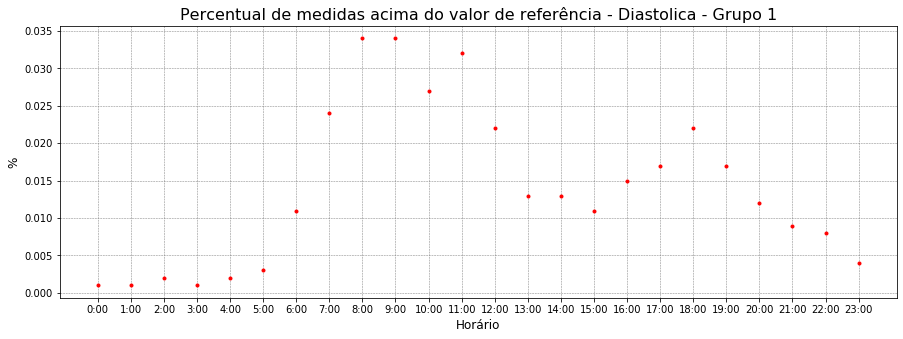

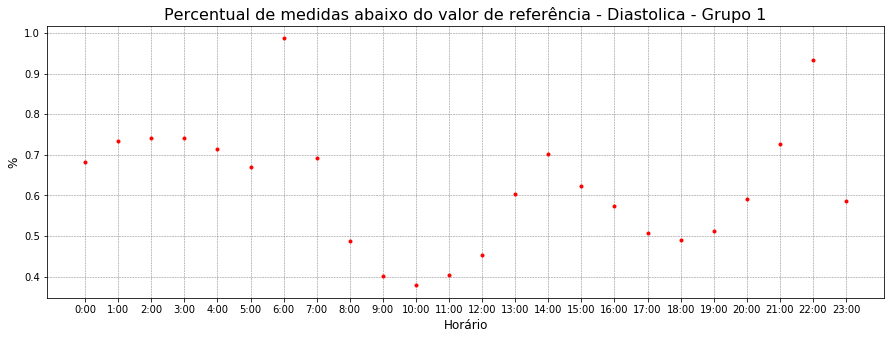

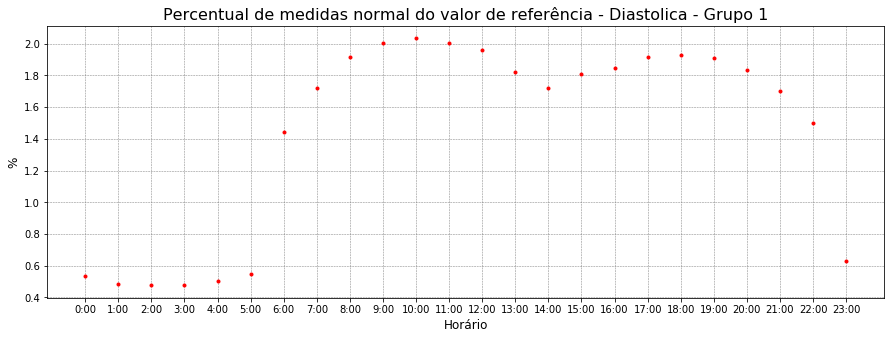

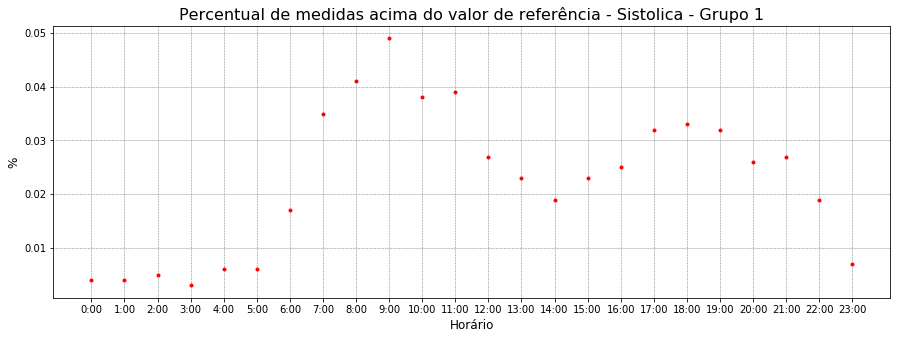

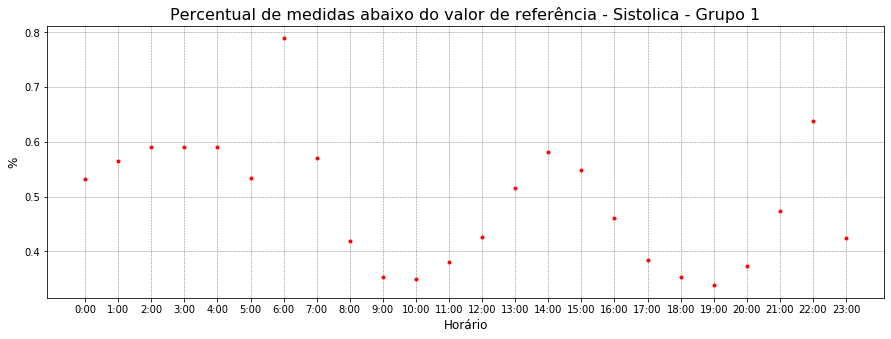

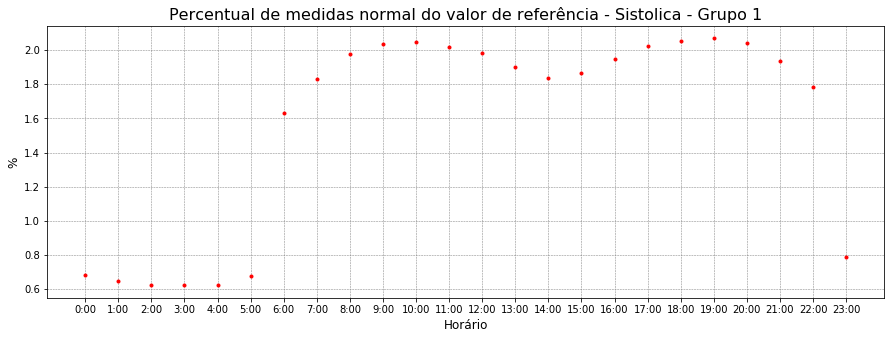

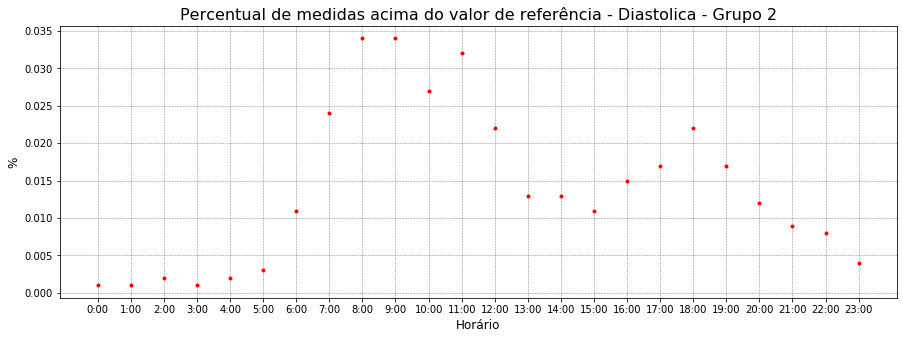

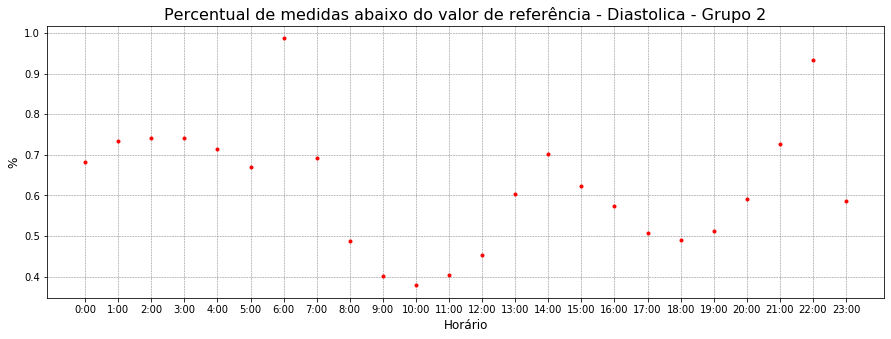

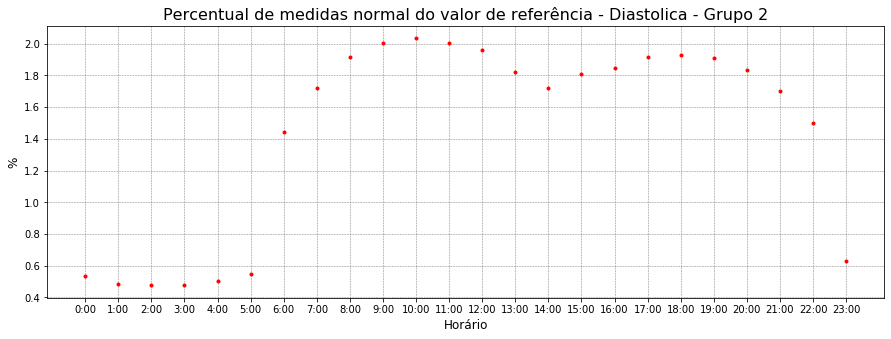

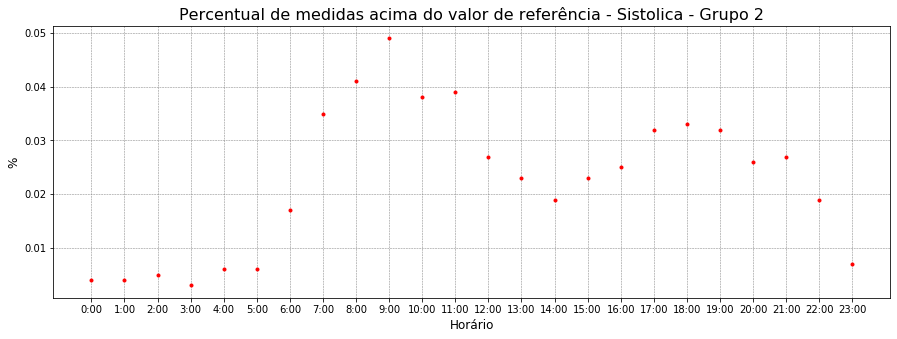

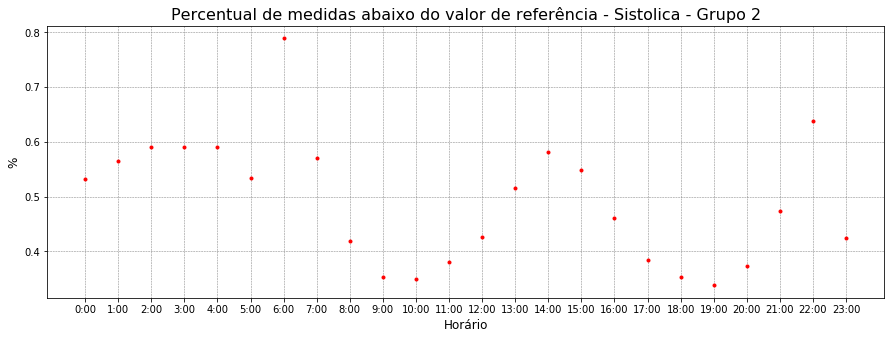

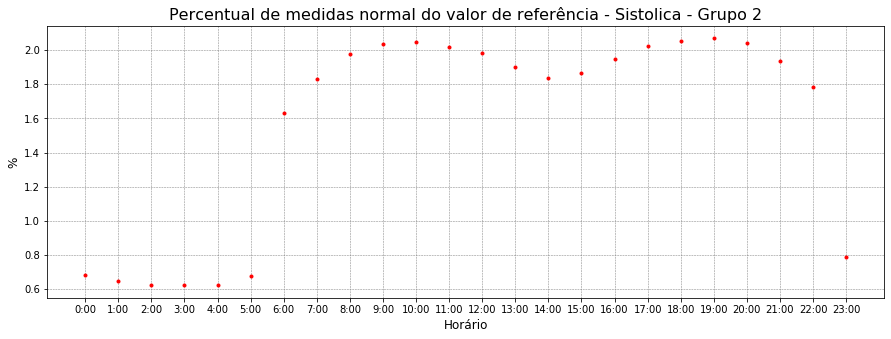

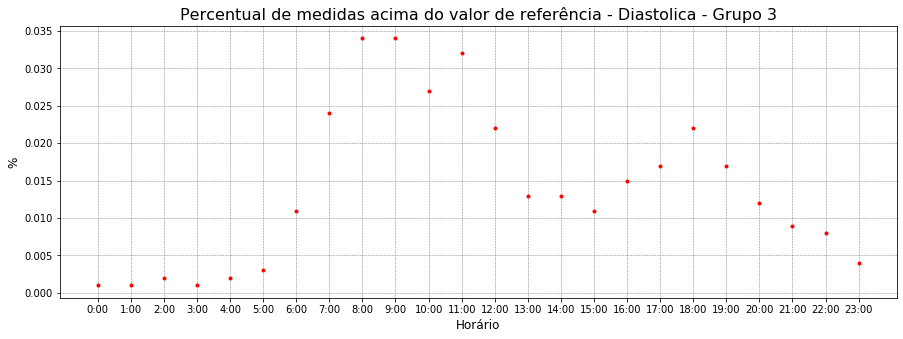

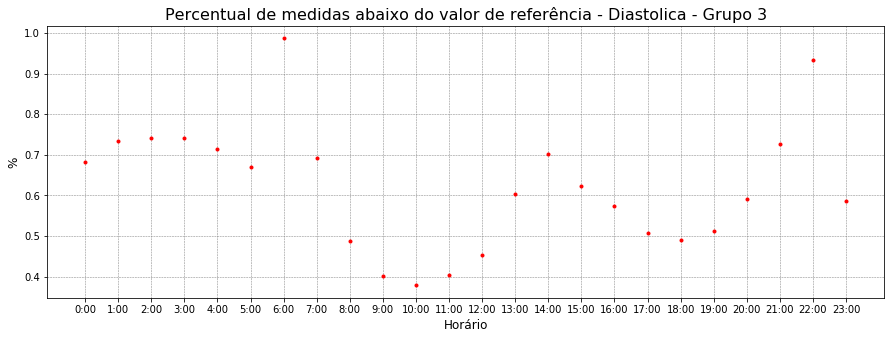

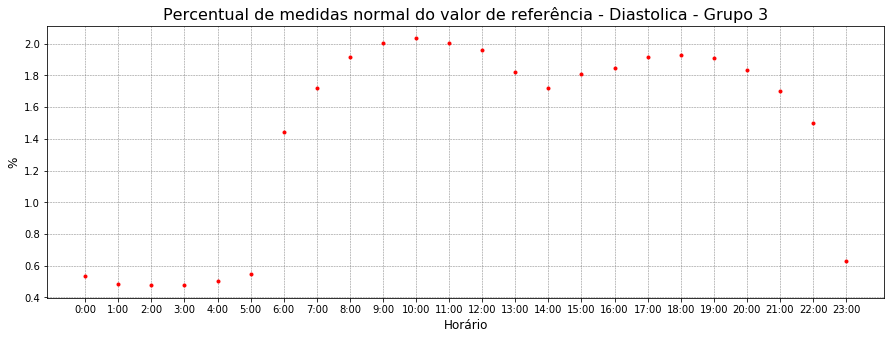

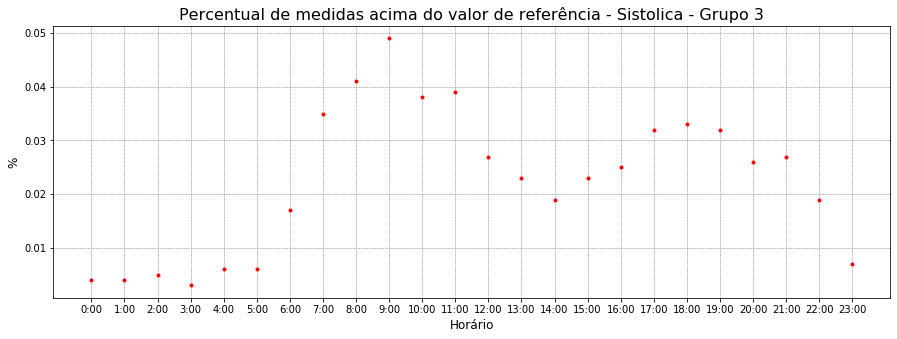

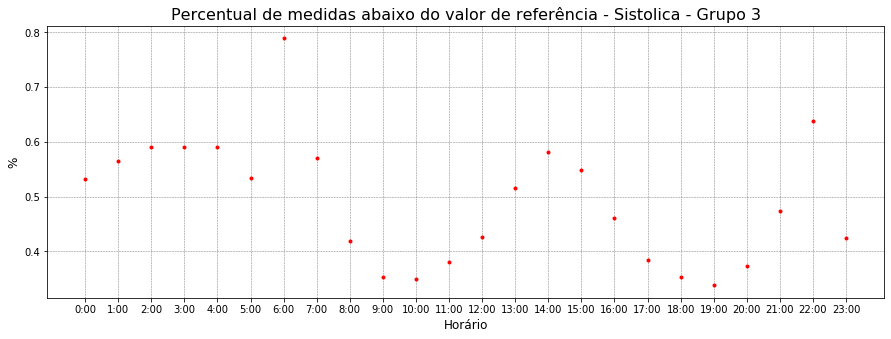

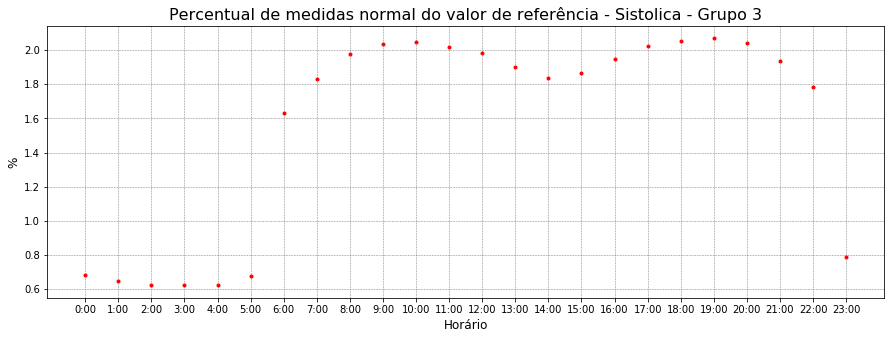

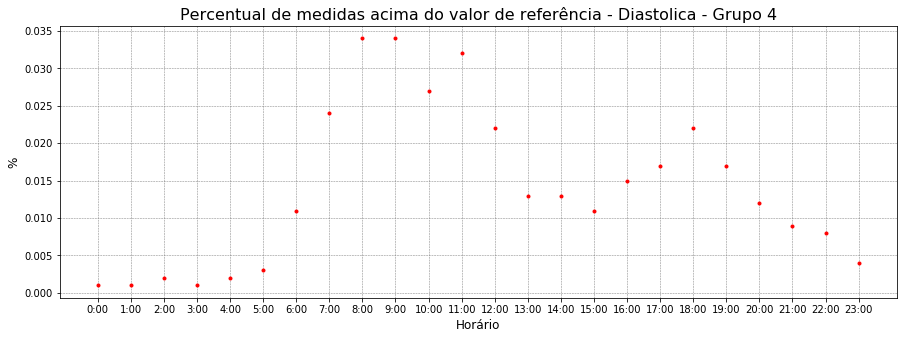

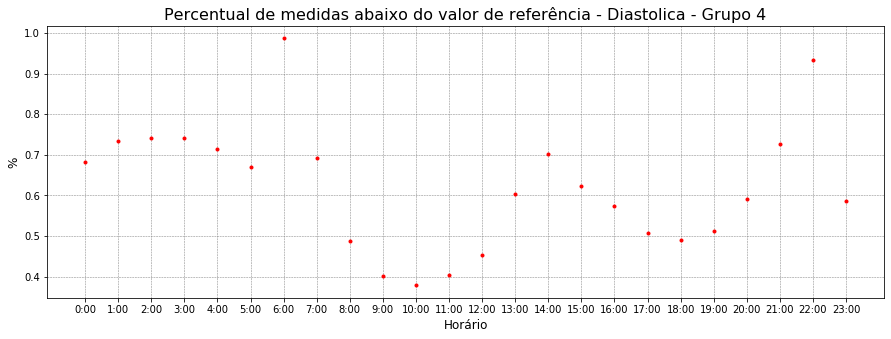

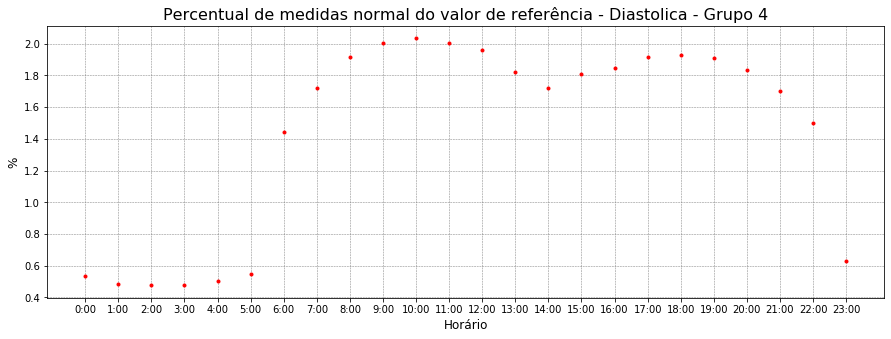

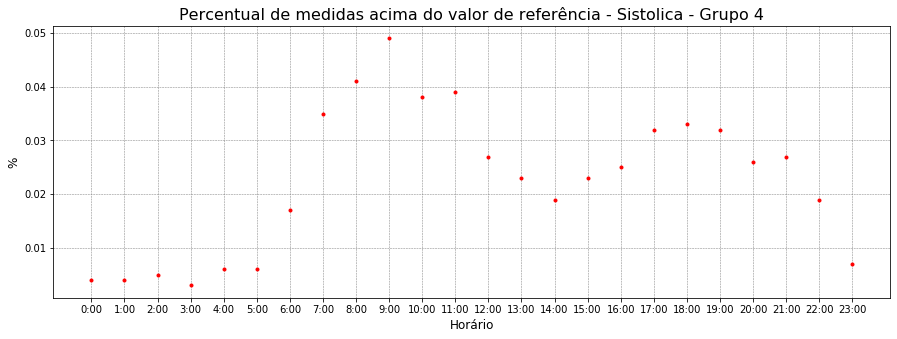

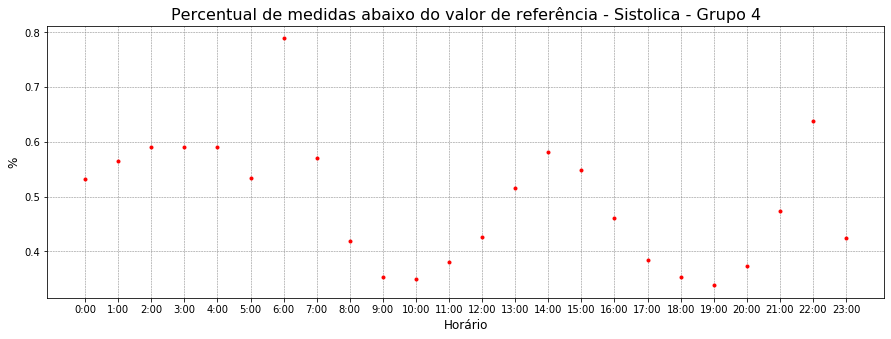

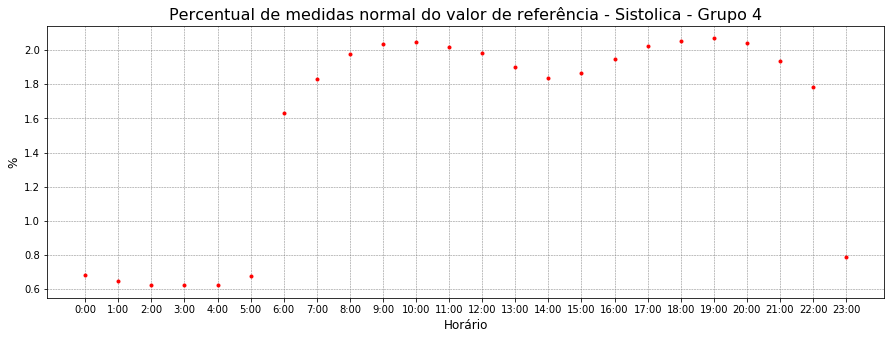

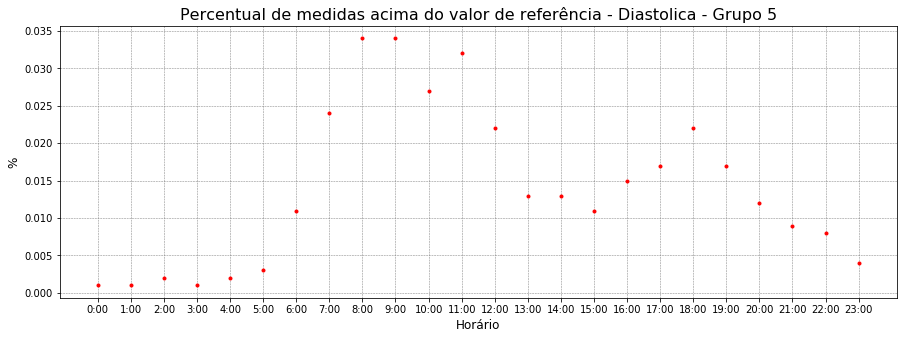

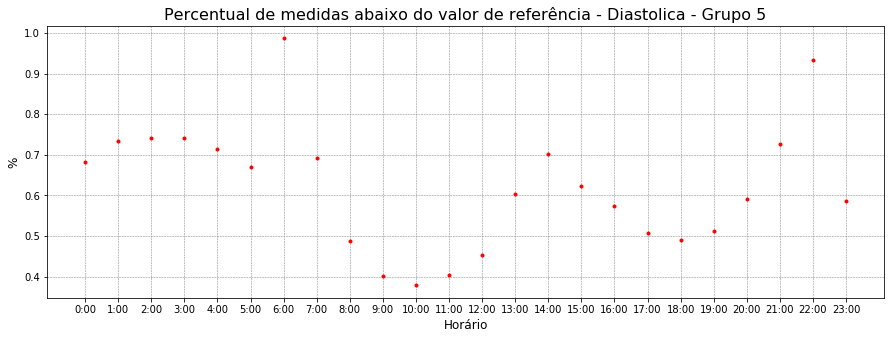

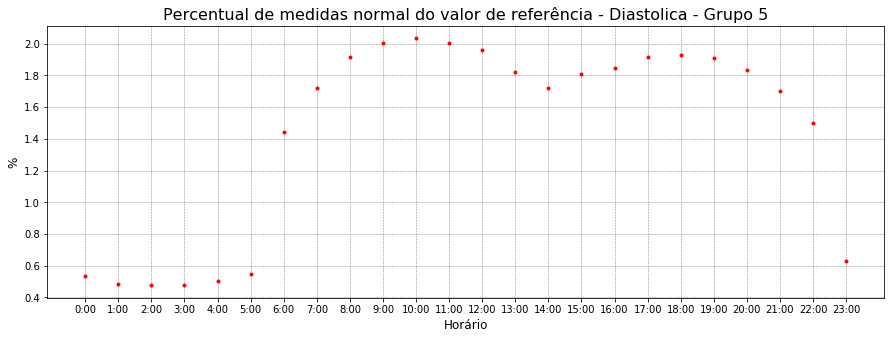

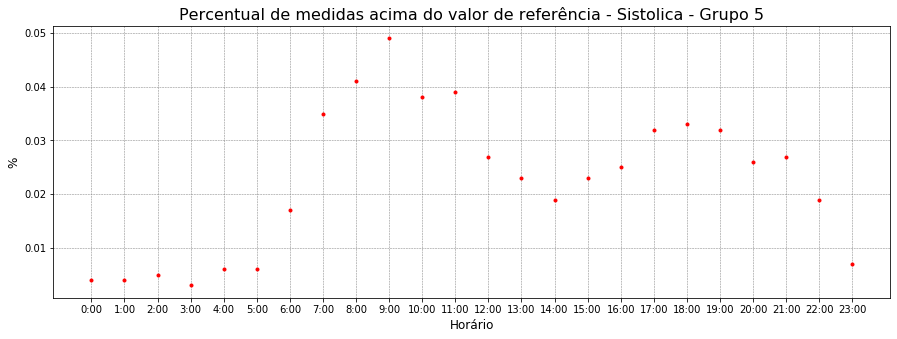

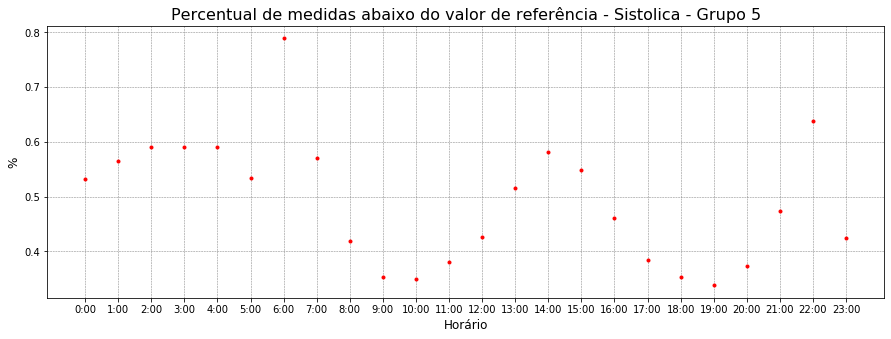

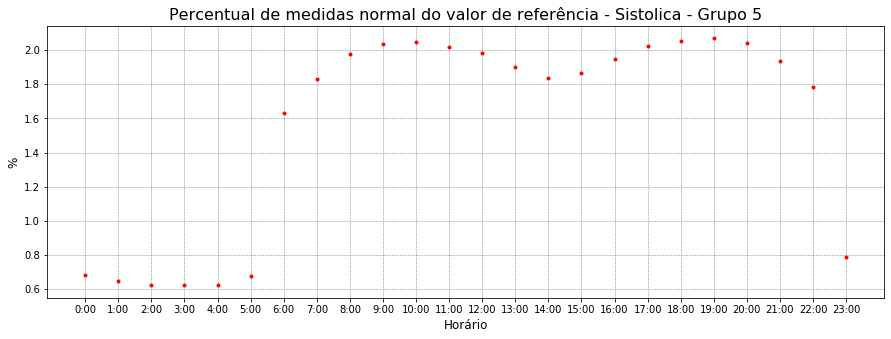

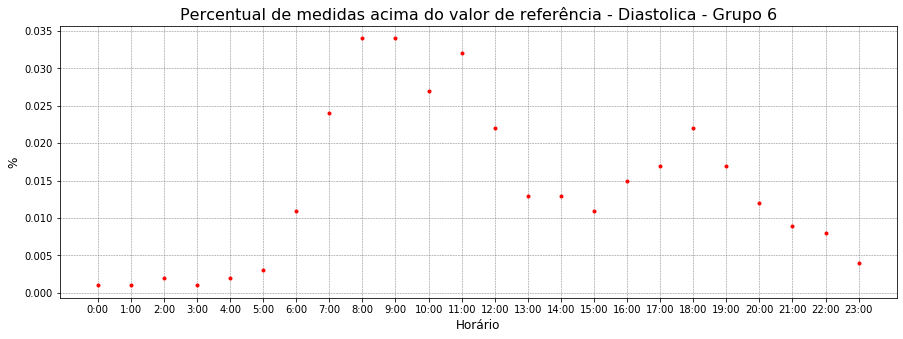

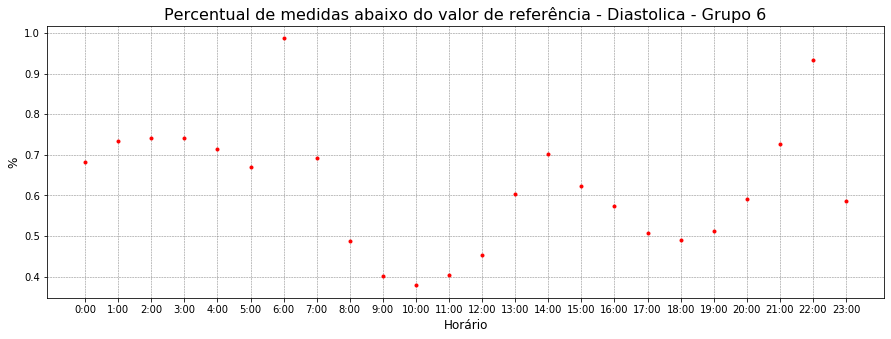

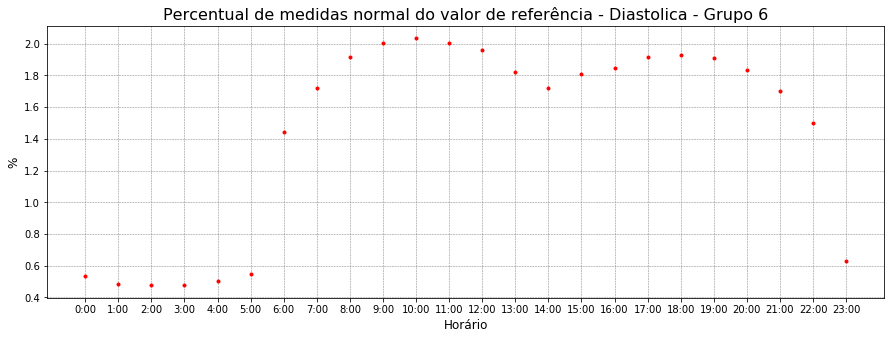

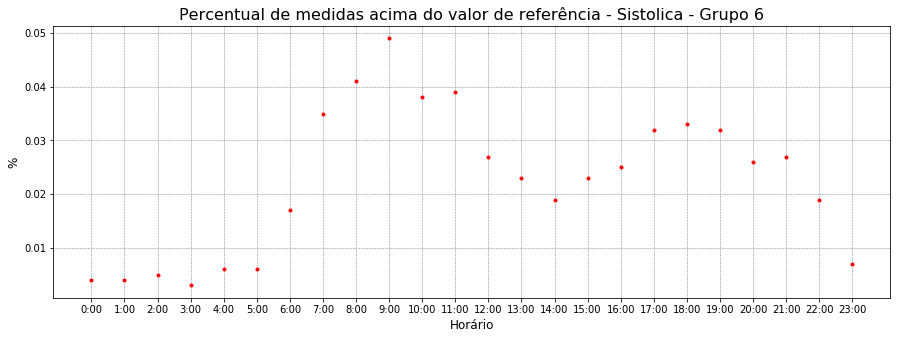

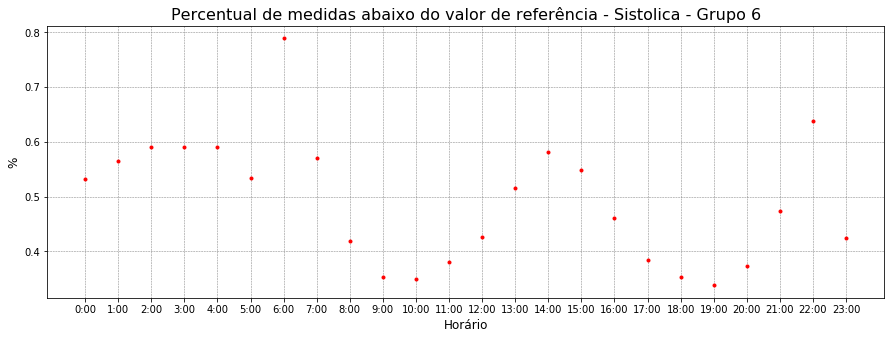

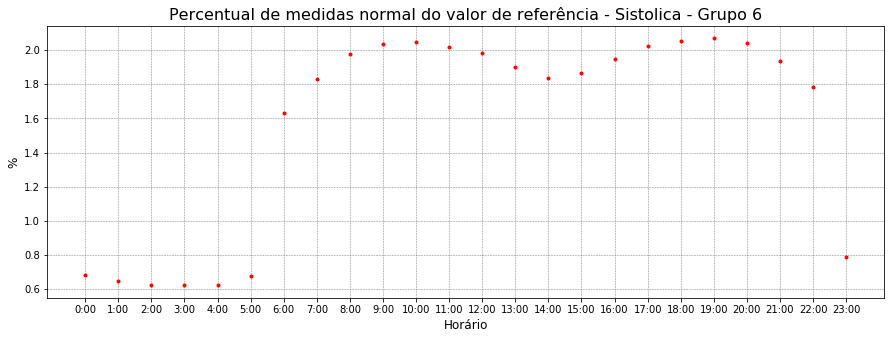

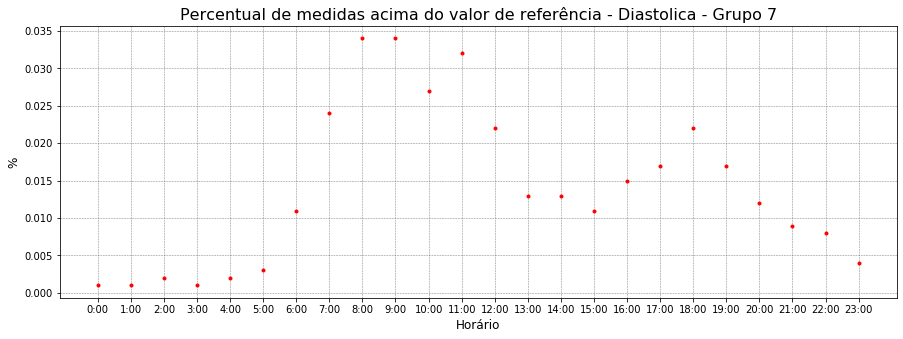

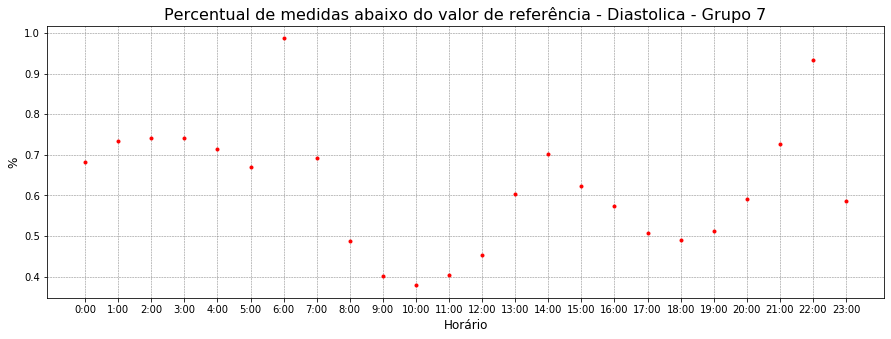

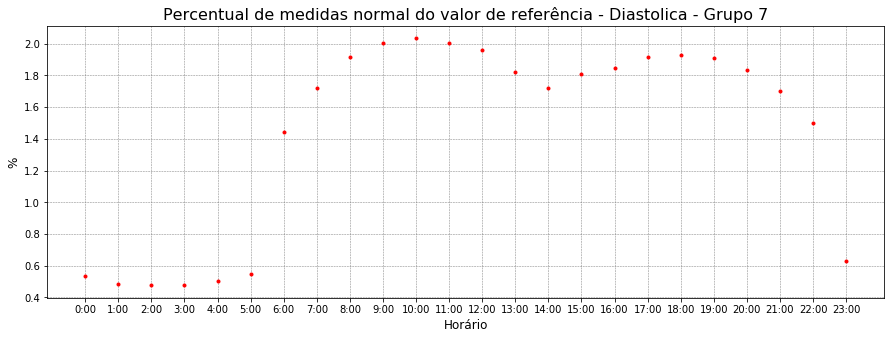

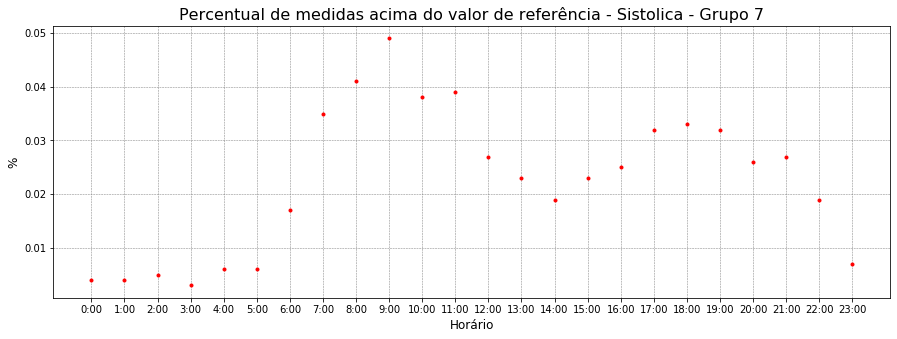

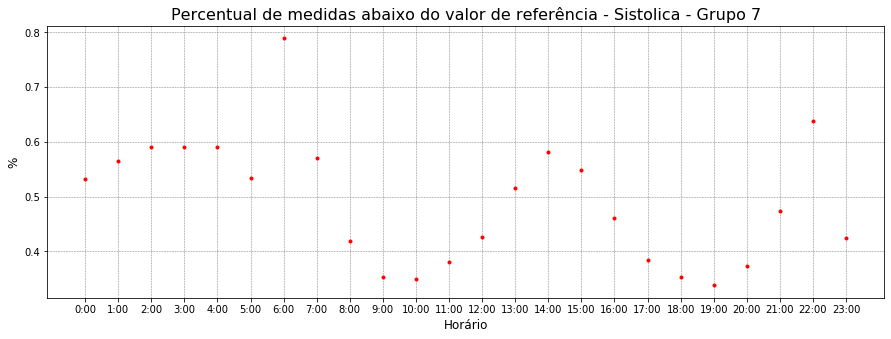

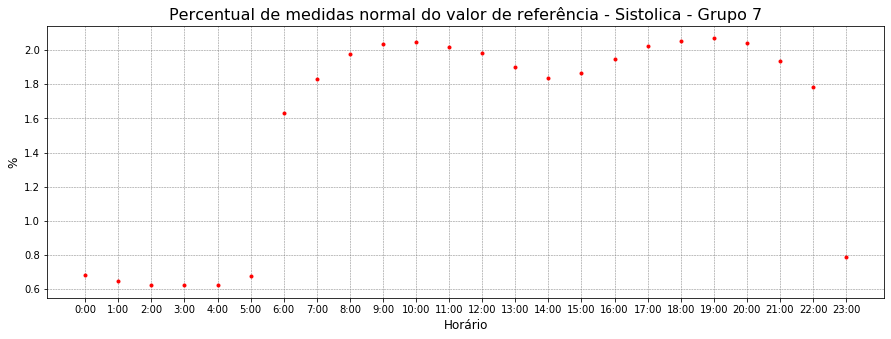

In [14]:
for grupo in range(len(lista_contagem)):
    df_grupo = lista_contagem[grupo].copy()
    df_grupo = lista_contagem[0].copy()
    df_grupo['tipo'] = df_grupo['Horário'].apply(lambda x: x.split(' ')[0])
    df_grupo['tipo2'] = df_grupo['Horário'].apply(lambda x: x.split(' ')[4])
    df_grupo['Horário'] = df_grupo['Horário'].apply(lambda x: x.split(' ')[1])

    df_grupo_diast = df_grupo[df_grupo['tipo'] == 'Diast'].loc[:,['Horário','%','tipo2']]
    df_grupo_diast_max = df_grupo_diast[df_grupo_diast['tipo2'] == 'Max'].loc[:,['Horário','%']]
    df_grupo_diast_min = df_grupo_diast[df_grupo_diast['tipo2'] == 'Min'].loc[:,['Horário','%']]
    df_grupo_diast_normal = df_grupo_diast[df_grupo_diast['tipo2'] == 'Normal'].loc[:,['Horário','%']]
    
    df_grupo_sist = df_grupo[df_grupo['tipo'] == 'Sist'].loc[:,['Horário','%','tipo2']]
    df_grupo_sist_max = df_grupo_sist[df_grupo_sist['tipo2'] == 'Max'].loc[:,['Horário','%']]
    df_grupo_sist_min = df_grupo_sist[df_grupo_sist['tipo2'] == 'Min'].loc[:,['Horário','%']]
    df_grupo_sist_normal = df_grupo_sist[df_grupo_sist['tipo2'] == 'Normal'].loc[:,['Horário','%']]
    
    grafico_percentual(df_grupo_diast_max, grupo + 1, 'Diastolica', 'acima')
    grafico_percentual(df_grupo_diast_min, grupo + 1, 'Diastolica', 'abaixo')
    grafico_percentual(df_grupo_diast_normal, grupo + 1, 'Diastolica', 'normal')
    
    grafico_percentual(df_grupo_sist_max, grupo + 1, 'Sistolica', 'acima')
    grafico_percentual(df_grupo_sist_min, grupo + 1, 'Sistolica', 'abaixo')
    grafico_percentual(df_grupo_sist_normal, grupo + 1, 'Sistolica', 'normal')

In [15]:
lista = [float(x.split(' ')[1].replace(':','.')) for x in df_abordagem.loc[:,'sist 9:00':'diast 8:45'].columns]
lista.sort()
dia = list()
noite = list()
for i in lista:
    if i >= 6 and i <= 22.45:
        dia.append(i)
    else:
        noite.append(i)
print(f'Dia: {len(dia)}\nNoite: {len(noite)}')

Dia: 136
Noite: 28


In [16]:
qtd_total_picos = np.sum(contagem_picos,axis=0).sort_values(ascending=False)
qtd_total_picos = qtd_total_picos.to_frame().reset_index()
qtd_total_picos.columns = ['Horário','QTD Picos']
qtd_total_picos['%'] = np.round(qtd_total_picos['QTD Picos'] / sum(qtd_total_picos['QTD Picos']) * 100,3)
qtd_total_picos

,Horário,QTD Picos,%
0,Sist 14:00 - 14:45 Normal,61840,1.960
1,Sist 15:00 - 15:45 Normal,61640,1.953
2,Sist 13:00 - 13:45 Normal,61569,1.951
3,Sist 16:00 - 16:45 Normal,61449,1.947
4,Sist 17:00 - 17:45 Normal,61095,1.936
...,...,...,...
139,Sist 2:00 - 2:30 Max,2535,0.080
140,Diast 4:00 - 4:30 Max,2020,0.064
141,Diast 1:00 - 1:30 Max,2017,0.064
142,Diast 3:00 - 3:30 Max,1886,0.060


In [17]:
#  Grava a quantidade de picos por cada período de tempo informado para calcular
#qtd_total_picos.to_csv ( DIR_SALVA / "frequencia_picos.csv", sep=";", encoding="latin1")

In [18]:
doencas = dataset.loc[:,'Hipotensao':'Normotenso']
cabecalho = doencas.columns

In [19]:
dataset[eval("(dataset['Hipotensao'] == True) & (dataset['Sistolica Isolada'] == True) & (dataset['Dipping'] == True) & (dataset['Morning Surge'] == True) & (dataset['Whitecoat'] == True)")]

,numero_identificacao,data_nascimento,genero,idade,peso,altura,IMC,data_exame,sist 9:00,sist 9:15,...,Mediana Diastolica em 24h,AUC Sistolica em 24h,AUC Diastolica em 24h,AUC PP Daytime,AUC PP Nighttime,DP Sistolica em 24h,DP Diastolica em 24h,Diferenca % Dipping,Picos Sistolica,Picos Diastolica
7512,8399,1963-01-05,1,56.0,94.0,"1,73",31.4,2019-07-18 08:35:49,136.0,129.0,...,77.0,9630.0,6114.0,2938.0,539.5,11.46,8.68,1.11,4,0


In [21]:
for n in range(2, 12):
    df_contagem_doencas = pd.DataFrame()
    for i in combinations(cabecalho,n):
        comando = ""
        coluna = ""
        for j in range(len(i)):
            if j == 0:
                comando += f"(doencas[{repr(i[j])}] == True)"
                coluna += f"{i[j]}"
            else:
                comando += f" & (doencas[{repr(i[j])}] == True)"
                coluna += f"&{i[j]}"

        df_contagem_doencas[coluna] = [len(doencas[eval(comando)])]
    df_contagem_doencas = df_contagem_doencas.T.sort_values(by=[0],ascending = False).reset_index()
    df_contagem_doencas.columns = ['Doencas','QTD']
    df_contagem_doencas
    lista.append(len(df_contagem_doencas))
    df_contagem_doencas.to_excel ( DIR_SALVA / f"combinacao_{n}_doencas.xlsx", index = False)


In [22]:
n = 4
df_contagem_doencas = pd.DataFrame()
for i in combinations(cabecalho,n):
    comando = ""
    coluna = ""
    for j in range(len(i)):
        if j == 0:
            comando += f"(doencas[{repr(i[j])}] == True)"
            coluna += f"{i[j]}"
        else:
            comando += f" & (doencas[{repr(i[j])}] == True)"
            coluna += f"&{i[j]}"

    df_contagem_doencas[coluna] = [len(doencas[eval(comando)])]
    if(len(doencas[eval(comando)]) > 5):
        print(repr(comando))
df_contagem_doencas = df_contagem_doencas.T.sort_values(by=[0], ascending = False).reset_index()
df_contagem_doencas.columns = ['Doencas','QTD']
df_contagem_doencas

"(doencas['Hipotensao'] == True) & (doencas['Diastolica Isolada'] == True) & (doencas['Non Dipping'] == True) & (doencas['Whitecoat'] == True)"
"(doencas['Hipotensao'] == True) & (doencas['Dipping'] == True) & (doencas['Morning Surge'] == True) & (doencas['Whitecoat'] == True)"


,Doencas,QTD
0,Hipotensao&Dipping&Morning Surge&Whitecoat,2116
1,Hipotensao&Diastolica Isolada&Non Dipping&Whit...,15
2,Hipotensao&Diastolica Isolada&Dipping&Morning ...,2
3,Hipotensao&Diastolica Isolada&Reverse Dipping&...,2
4,Hipotensao&Sistolica Isolada&Non Dipping&White...,2
...,...,...
325,Hipotensao&Morning Surge&Masked&Whitecoat,0
326,Hipotensao&Reverse Dipping&Whitecoat&Normotenso,0
327,Hipotensao&Reverse Dipping&Masked&Normotenso,0
328,Hipotensao&Reverse Dipping&Masked&Whitecoat,0


In [23]:
busca = "(doencas['Hipotensao'] == True) & (doencas['Diastolica Isolada'] == True) & (doencas['Non Dipping'] == True) & (doencas['Whitecoat'] == True)"
ids = dataset[eval(busca.replace('doencas','dataset'))]['numero_identificacao']
ids

399        440
4398      4881
9039     10080
10421    11631
10558    11797
11458    12836
11511    12901
12635    14199
13935    15709
14114    15911
15485    17519
16051    18137
16479    18603
18736    21224
18769    21262
Name: numero_identificacao, dtype: int64